# Financial News Sentiment Analysis Training
This notebook trains a BERT model on the Financial PhraseBank dataset using TensorFlow, ready for Google Colab.

In [1]:
!pip install transformers datasets tensorflow torch  scikit-learn

## Imports

In [2]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Load Financial PhraseBank Dataset

In [7]:
import pandas as pd

# Read file line by line
with open("Sentences_50Agree.txt", "r", encoding="latin1") as f:
    lines = f.readlines()

# Split sentence and label
data = []
labels_in_file = set()
for line in lines:
    line = line.strip()
    if not line:
        continue
    sentence, label = line.rsplit('@', 1)
    label = label.lower().strip()
    labels_in_file.add(label)
    data.append([sentence, label])

print(f"Labels found in file: {labels_in_file}")

df = pd.DataFrame(data, columns=['sentence', 'label'])
label_map = {'negative':0, 'neutral':1, 'positive':2}
df['label'] = df['label'].map(label_map)
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)
print(df.head())
print(df['label'].value_counts())

Labels found in file: {'negative', 'positive', 'neutral'}
                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  Technopolis plans to develop in stages an area...      1
2  The international electronic industry company ...      0
3  With the new production plant the company woul...      2
4  According to the company 's updated strategy f...      2
label
1    2879
2    1363
0     604
Name: count, dtype: int64


## Encode Labels

In [5]:
label_map = {'negative':0, 'neutral':1, 'positive':2}
df['label'] = df['label'].map(label_map)

## Train/Validation Split

In [8]:
train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 4361, Validation samples: 485


## Tokenization

In [9]:
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(sentences.tolist(), truncation=True, padding=True, max_length=max_length)
        self.labels = labels.tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = FinancialDataset(train_df['sentence'], train_df['label'], tokenizer)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label'], tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU (⚠️ slower)")


Using device: cuda
Using GPU: Tesla T4


## Build and Compile Model

In [21]:
# model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
# steps_per_epoch = len(train_df) // 16
# total_train_steps = steps_per_epoch * 3
# optimizer, schedule = create_optimizer(init_lr=3e-5, num_warmup_steps=int(0.1*total_train_steps), num_train_steps=total_train_steps)

# model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AttributeError: 'BertForSequenceClassification' object has no attribute 'summary'

In [12]:
optimizer = AdamW(model.parameters(), lr=3e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1*num_training_steps),
    num_training_steps=num_training_steps
)

## Train the Model

In [13]:
from torch.nn import CrossEntropyLoss

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    print(f"Epoch {epoch+1} completed.")

 33%|███▎      | 274/819 [01:27<02:46,  3.28it/s]

Epoch 1 completed.


 67%|██████▋   | 546/819 [03:02<01:34,  2.89it/s]

Epoch 2 completed.


100%|██████████| 819/819 [04:36<00:00,  2.89it/s]

Epoch 3 completed.


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn.functional as F

# --- Evaluation ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

# --- Metrics ---
acc = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive']))



Validation Accuracy: 0.8330

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.84      0.83        61
     Neutral       0.88      0.85      0.87       288
    Positive       0.74      0.79      0.77       136

    accuracy                           0.83       485
   macro avg       0.82      0.83      0.82       485
weighted avg       0.84      0.83      0.83       485


Confusion Matrix:
[[ 51   8   2]
 [  7 245  36]
 [  4  24 108]]


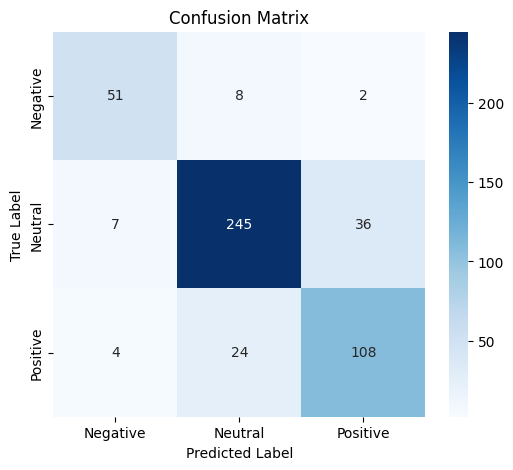

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
labels = ['Negative', 'Neutral', 'Positive']

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [18]:
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch
import torch.nn.functional as F

# Load model and tokenizer
model_path = "/content/saved_model/pt_model"
tokenizer_path = "/content/saved_model/tokenizer"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(tokenizer_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
test_sentences = [
    "Tesla shares soar after strong quarterly earnings report.",
    "Apple warns of slower iPhone sales due to supply chain issues.",
    "Oil prices remain steady amid global economic uncertainty.",
    "Microsoft announces major layoffs to cut costs.",
    "Amazon's revenue beats expectations as holiday demand surges."
]


In [20]:
# Tokenize
encodings = tokenizer(test_sentences, return_tensors='pt', padding=True, truncation=True, max_length=128)
encodings = {key: val.to(device) for key, val in encodings.items()}

# Predict
with torch.no_grad():
    outputs = model(**encodings)
    probs = F.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1)

# Convert predictions
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
results = [label_map[p.item()] for p in preds]

# Show results
for sent, label in zip(test_sentences, results):
    print(f"{label:>8} → {sent}")


Positive → Tesla shares soar after strong quarterly earnings report.
Negative → Apple warns of slower iPhone sales due to supply chain issues.
 Neutral → Oil prices remain steady amid global economic uncertainty.
Positive → Microsoft announces major layoffs to cut costs.
Positive → Amazon's revenue beats expectations as holiday demand surges.


## Save Model & Tokenizer

In [15]:
model.save_pretrained('/content/saved_model/pt_model')
tokenizer.save_pretrained('/content/saved_model/tokenizer')
print("✅ Model and tokenizer saved to /content/saved_model/")

✅ Model and tokenizer saved to /content/saved_model/


In [16]:
from google.colab import files
import shutil

# Zip the whole folder
shutil.make_archive('financial_bert', 'zip', '/content/saved_model')

# Download it to your local computer
files.download('financial_bert.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>